In [4]:
from pandas import DataFrame, read_csv
from matplotlib.pyplot import figure, show, subplots
from libs.ds_charts import dummify, plot_line, multiple_line_chart
from  mlxtend.frequent_patterns import apriori, association_rules

data: DataFrame = read_csv('data/nyc_collisions_scaled_zscore.csv')
data = dummify(data, data.columns)
data.shape

(39025, 327)

### Patterns

Processing 9 combinations | Sampling itemset size 9 87
871 patterns


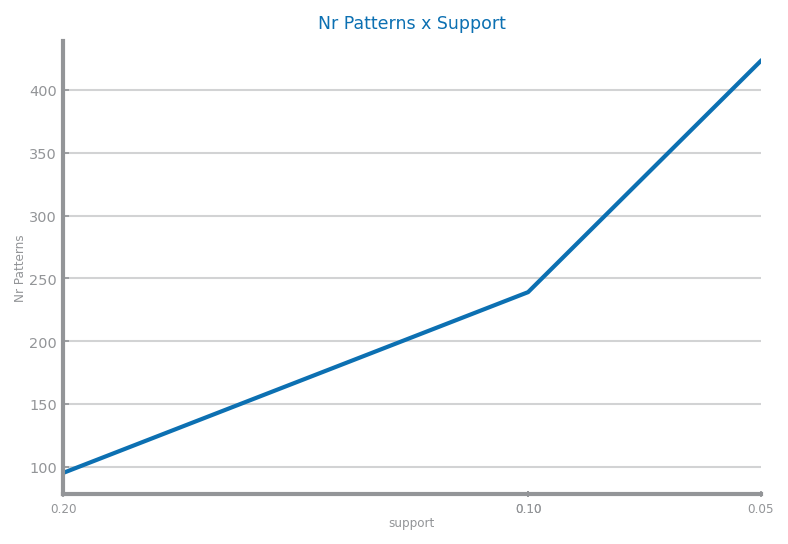

In [5]:
data = data.sample(40)
data = data.sample(20,axis=1)
MIN_SUP: float = 0.005
var_min_sup =[0.2, 0.1] + [i*MIN_SUP for i  in range(20, 0, -10)]

patterns: DataFrame = apriori(data, min_support=MIN_SUP, use_colnames=True, verbose=True)
print(len(patterns),'patterns')
nr_patterns = []
for sup in var_min_sup:
    pat = patterns[patterns['support']>=sup]
    nr_patterns.append(len(pat))

figure(figsize=(6, 4))
plot_line(var_min_sup, nr_patterns, title='Nr Patterns x Support', xlabel='support', ylabel='Nr Patterns')
show()

### Association Rules

In [6]:
MIN_CONF: float = 0.1
rules = association_rules(patterns, metric='confidence', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 11475 rules


In [9]:
def plot_top_rules(rules: DataFrame, metric: str, per_metric: str) -> None:
    _, ax = subplots(figsize=(6, 3))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'TOP 10 per Min {per_metric} - {metric}', fontweight="bold")
    text = ''
    cols = ['antecedents', 'consequents']
    rules[cols] = rules[cols].applymap(lambda x: tuple(x))
    for i in range(len(rules)):
        rule = rules.iloc[i]
        text += f"{rule['antecedents']} ==> {rule['consequents']}"
        text += f"(s: {rule['support']:.2f}, c: {rule['confidence']:.2f}, lift: {rule['lift']:.2f})\n"
    ax.text(0, 0, text)
    show()

def analyse_per_metric(rules: DataFrame, metric: str, metric_values: list) -> list:
    print(f'Analyse per {metric}...')
    conf = {'avg': [], 'top25%': [], 'top10': []}
    lift = {'avg': [], 'top25%': [], 'top10': []}
    top_conf = []
    top_lift = []
    nr_rules = []
    for m in metric_values:
        rs = rules[rules[metric] >= m]
        nr_rules.append(len(rs))
        conf['avg'].append(rs['confidence'].mean(axis=0))
        lift['avg'].append(rs['lift'].mean(axis=0))

        top_conf = rs.nlargest(int(0.25*len(rs)), 'confidence')
        conf['top25%'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(int(0.25*len(rs)), 'lift')
        lift['top25%'].append(top_lift['lift'].mean(axis=0))

        top_conf = rs.nlargest(10, 'confidence')
        conf['top10'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(10, 'lift')
        lift['top10'].append(top_lift['lift'].mean(axis=0))

    _, axs = subplots(1, 2, figsize=(10, 5), squeeze=False)
    multiple_line_chart(metric_values, conf, ax=axs[0, 0], title=f'Avg Confidence x {metric}',
                           xlabel=metric, ylabel='Avg confidence')
    multiple_line_chart(metric_values, lift, ax=axs[0, 1], title=f'Avg Lift x {metric}',
                           xlabel=metric, ylabel='Avg lift')
    show()

    plot_top_rules(top_conf, 'confidence', metric)
    plot_top_rules(top_lift, 'lift', metric)

    return nr_rules

### Quality evalutation per support

Analyse per support...


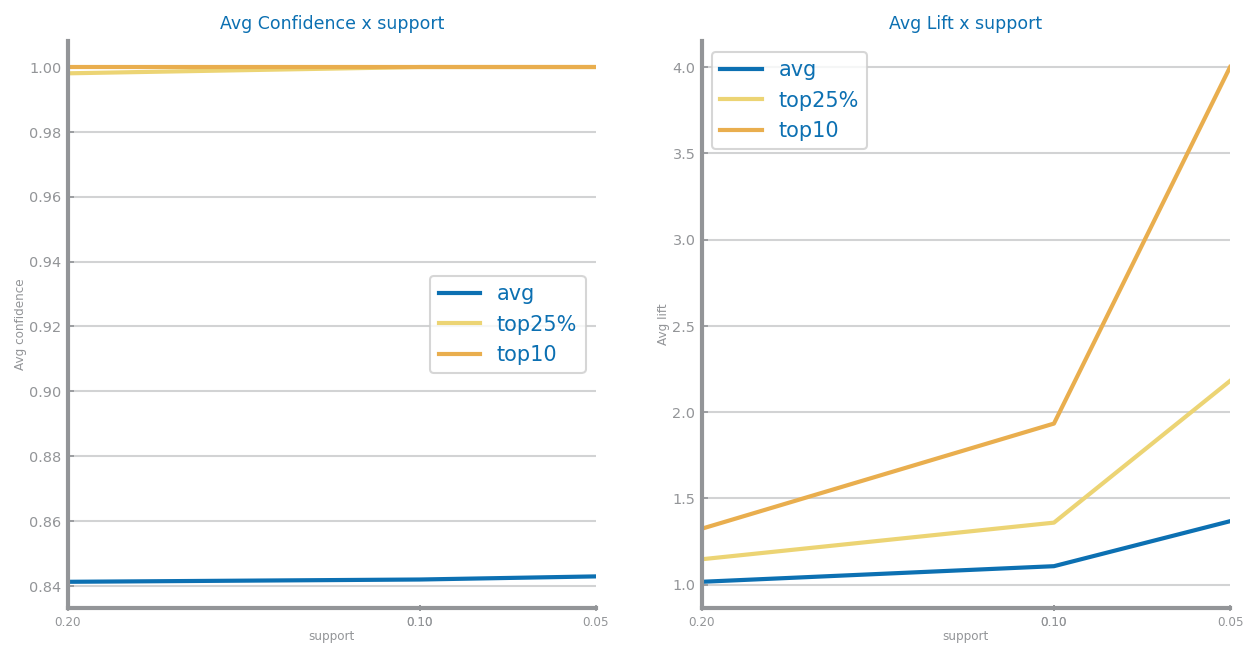

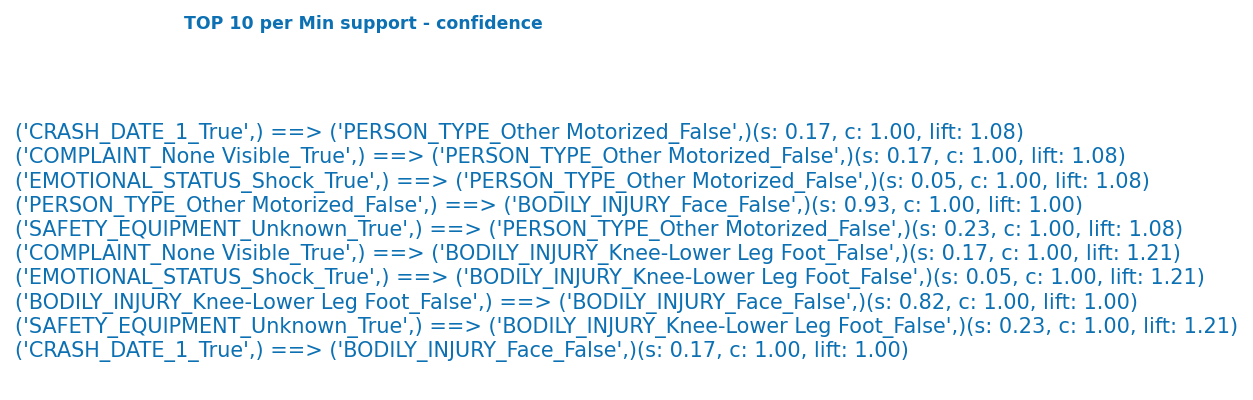

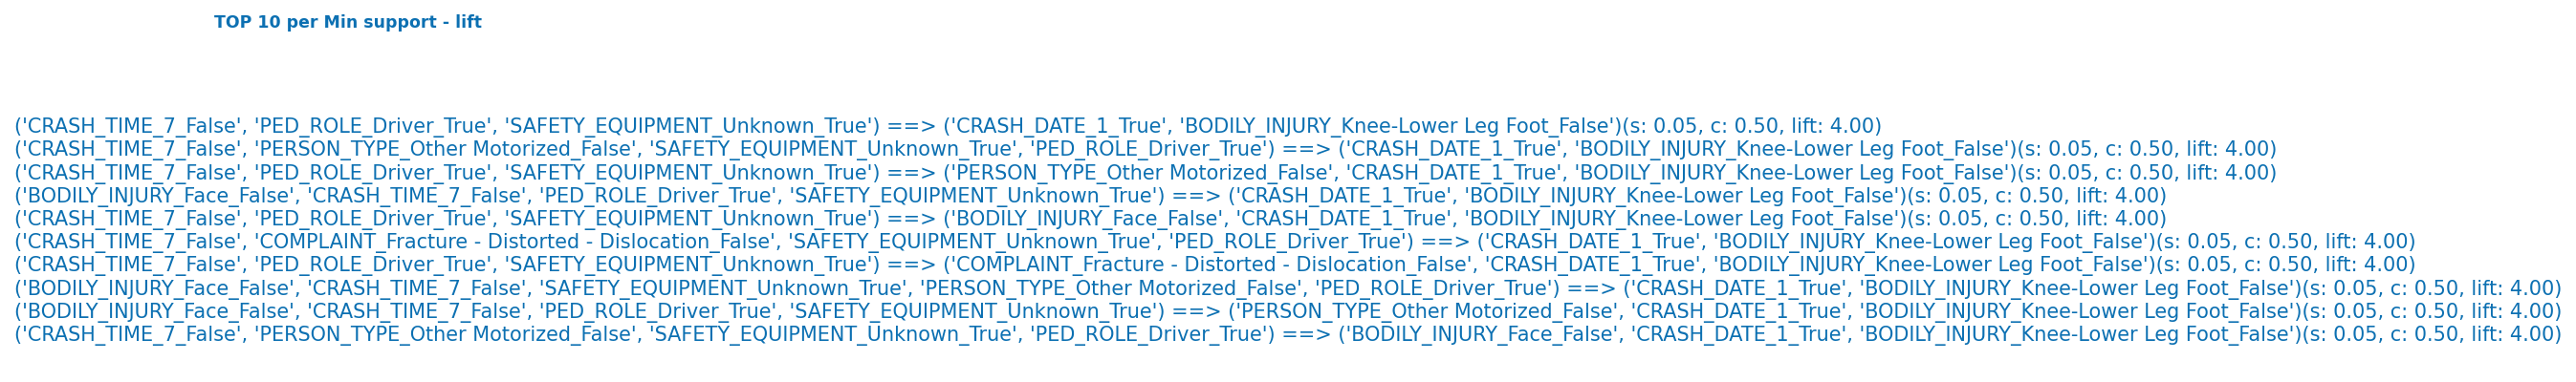

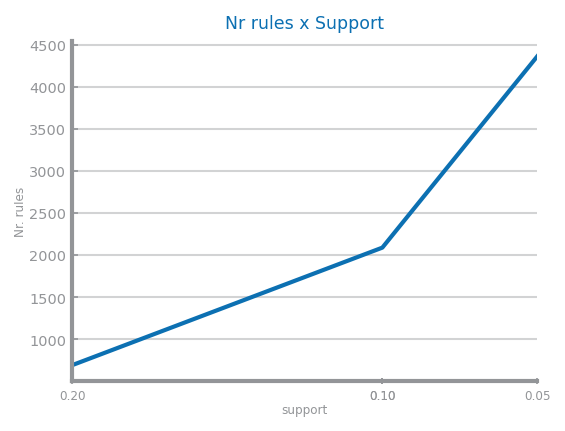

In [10]:
nr_rules_sp = analyse_per_metric(rules, 'support', var_min_sup)
plot_line(var_min_sup, nr_rules_sp, title='Nr rules x Support', xlabel='support', ylabel='Nr. rules', percentage=False)

### Quality evaluation per confidence

Analyse per confidence...


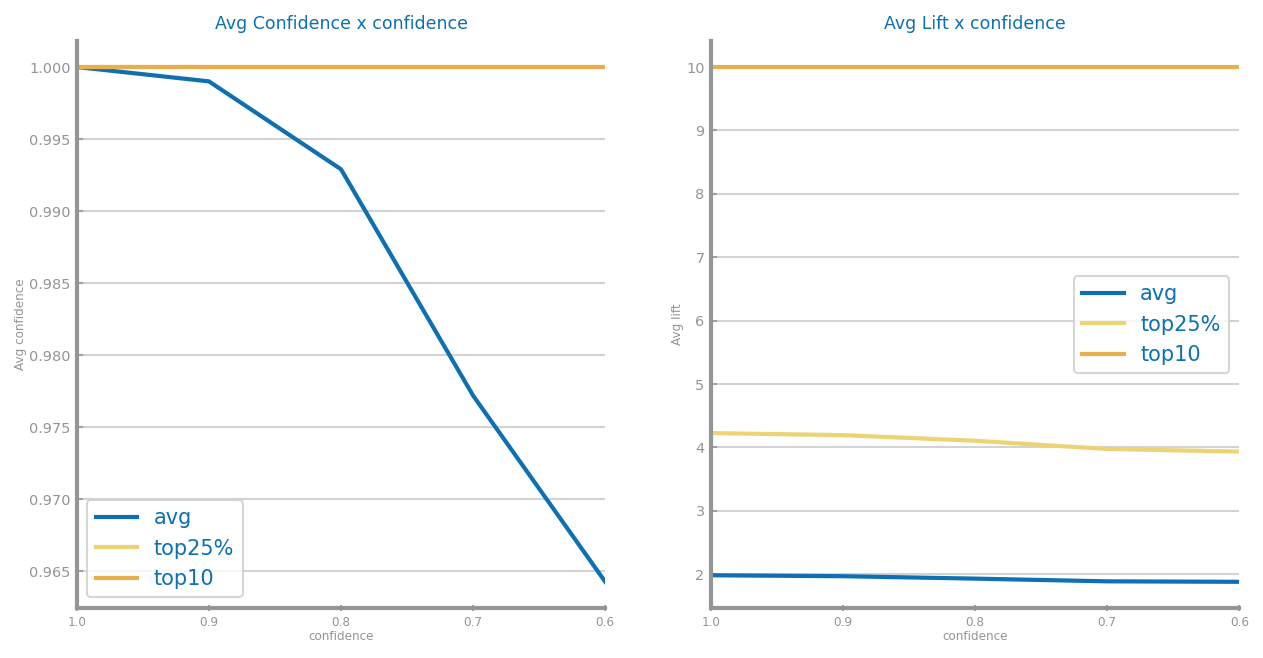

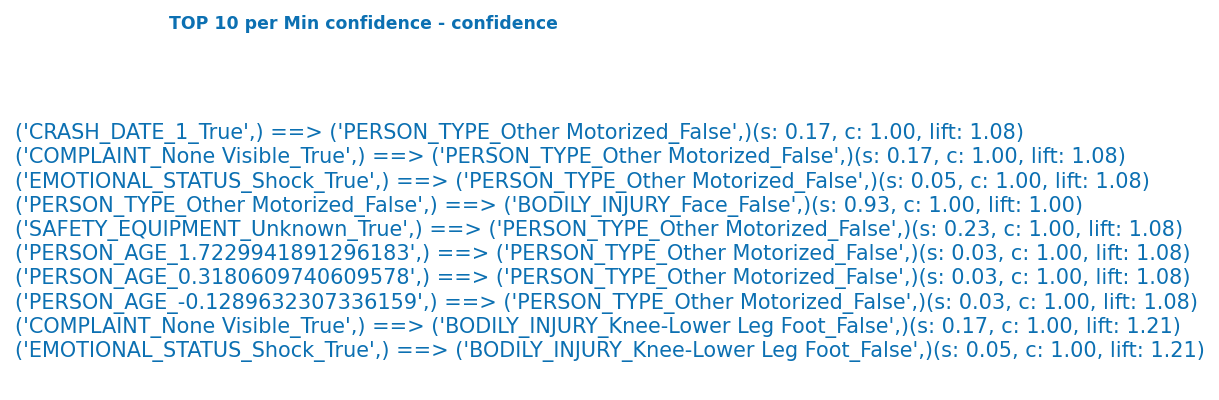

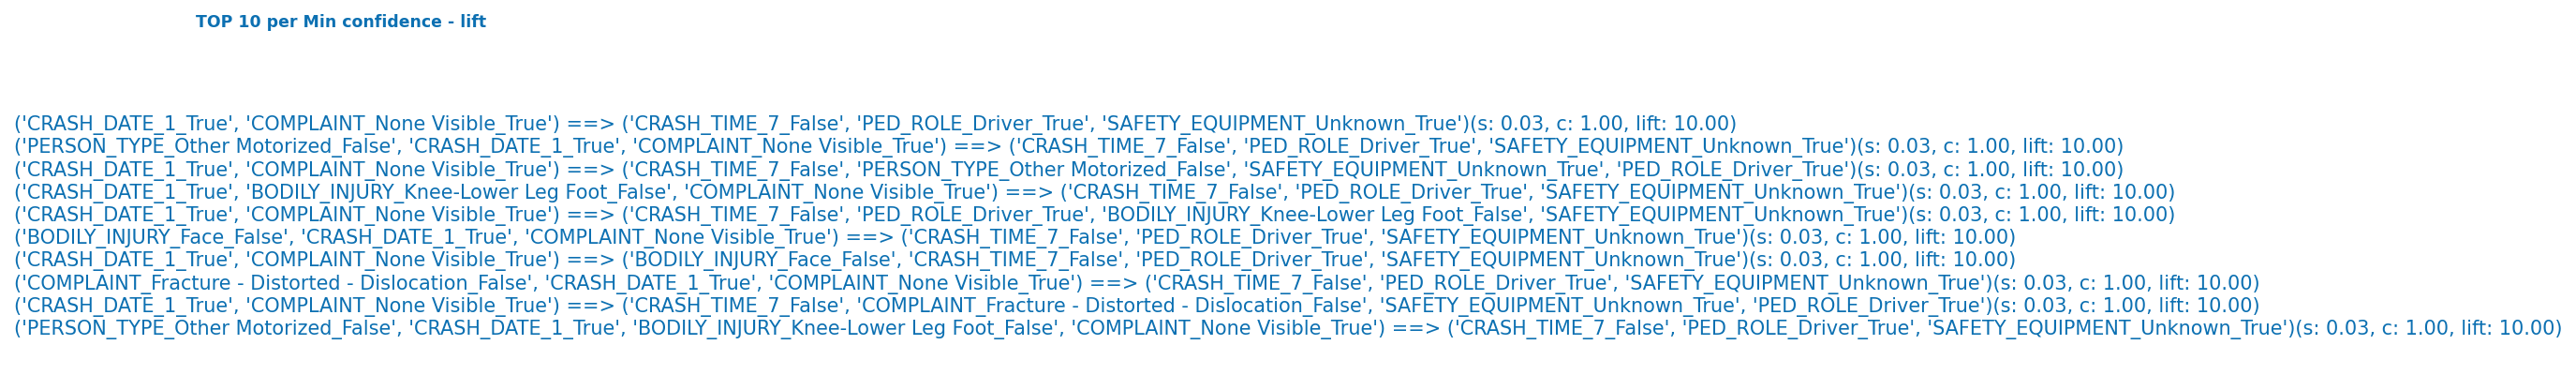

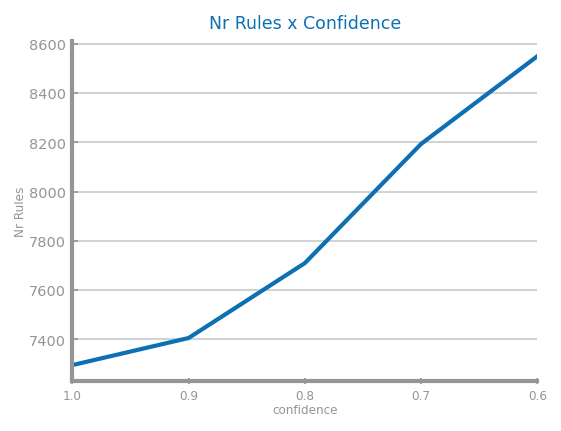

In [11]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf)
plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)